In [ ]:
!pip install pulp

import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint
import random
import pandas as pd
import pulp
import itertools
import requests
import random
from geopy.distance import geodesic
import time
import pandas as pd
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 38.4 MB/s eta 0:00:00


In [ ]:
def generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng):
    lat = random.uniform(sw_lat, ne_lat)
    lng = random.uniform(sw_lng, ne_lng)
    return lat, lng

def snap_to_road(lat, lng, api_key):
    url = f'https://roads.googleapis.com/v1/nearestRoads?points={lat},{lng}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if 'snappedPoints' in data and len(data['snappedPoints']) > 0:
        snapped_point = data['snappedPoints'][0]['location']
        return snapped_point['latitude'], snapped_point['longitude']
    return None

def get_road_distance_time(origin, destination, api_key):
    origin_str = f'{origin[0]}, {origin[1]}'
    destination_str = f'{destination[0]}, {destination[1]}'
    departure_time = int(time.time()) + 24 * 3600
    url = (
        f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&origins={origin_str}'
        f'&destinations={destination_str}&mode=driving&departure_time={departure_time}&key={api_key}'
    )
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        element = data['rows'][0]['elements'][0]
        if element['status'] == 'OK':
            # Extract distance in km
            distance_text = element['distance']['text']
            distance = float(distance_text.replace(' km', '').replace(',', ''))

            # Extract duration in minutes
            duration_text = element['duration']['text']
            duration_parts = duration_text.split()
            duration = int(duration_parts[0])
            if "hour" in duration_text:
                duration = int(duration_parts[0]) * 60 + int(duration_parts[2])

            return distance, duration
        else:
            return None, None
    else:
        return None, None

def find_center(sw_lat, sw_lng, ne_lat, ne_lng):
    center_lat = (sw_lat + ne_lat) / 2
    center_lng = (sw_lng + ne_lng) / 2
    return center_lat, center_lng

def generate_list(n, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")
    result = [0]
    random_values = np.random.rand(n - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    result.extend(rounded_values)

    return result

def crop_matrix(data, N):
    return [row[:N] for row in data[:N]]

import numpy as np

def generate_demand_list(n, m, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if m >= n:
        raise ValueError("M must be less than N.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")

    random_values = np.random.rand(n - m - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    zeros_list = [0] * m

    result = list(rounded_values) + zeros_list

    random.shuffle(result)

    result = [-1] + result

    return result
def replace_zeros_with_sum(input_list, target_sum):
    zero_positions = [i for i, value in enumerate(input_list) if value == 0]
    num_zeros = len(zero_positions)

    result = input_list.copy()

    if num_zeros == 0:
        raise ValueError("There are no zeros to replace in the list.")

    random_values = np.random.rand(num_zeros)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    for i, pos in enumerate(zero_positions):
        result[pos] = rounded_values[i]

    return result

def create_path_as_list(pairs_list):
    wanted_length = len(pairs_list)
    path = ''
    current_pair = next(pair for pair in pairs_list if pair[0] == 0)
    path += str(current_pair[0])

    next_start = current_pair[1]

    pairs_list.remove(current_pair)

    while len(path) < wanted_length:
        path += str(next_start)
        current_pair = next(pair for pair in pairs_list if pair[0] == next_start)
        pairs_list.remove(current_pair)
        next_start = current_pair[1]

    return path

def find_paths_vrb(edges, k):
    def find_path_vrb(current_path):
        if len(paths) >= k:
            return

        last_node = current_path[-1]

        if last_node == 0 and len(current_path) > 1:
            paths.append("->".join(map(str, current_path)))
            return

        for edge in edges:
            if edge[0] == last_node:
                find_path_vrb(current_path + [edge[1]])

    paths = []
    find_path_vrb([0])

    return paths
def repetitions(list1, list2):
  common_elements = set(list1) & set(list2)
  return (2*len(common_elements))/len(list1+list2)

def equal_paths(list1, list2):
  are_equal = sorted(list1) == sorted(list2)
  if are_equal:
    return 1
  else:
    return 0

In [ ]:
def create_cost_matrixes(df):
    real_distance_columns = [col for col in df.columns if col.startswith('Road Distance to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_raod = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Road Distance to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                if distance == "N/A":
                    cost_raod[i][j] = 1000000
                else:
                    cost_raod[i][j] = float(distance)


    real_distance_columns = [col for col in df.columns if col.startswith('Time to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_time = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Time to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                if distance == "N/A":
                    cost_time[i][j] = 1000000
                else:
                    cost_time[i][j] = float(distance)


    real_distance_columns = [col for col in df.columns if col.startswith('Real Distance to Point')]
    df_filtered = df[real_distance_columns]

    num_points = len(df_filtered)
    cost_real = [[0] * num_points for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i != j:
                column_name = f'Real Distance to Point {j + 1}'
                distance = df_filtered.iloc[i][column_name]

                if distance == "N/A":
                    cost_real[i][j] = 1000000
                else:
                    cost_real[i][j] = float(distance)

    return cost_raod, cost_time, cost_real

In [ ]:
df = pd.read_csv(os.path.join("", "VISUALIZATION_CRACOW"))
cost_R, cost_T, cost_G = create_cost_matrixes(df)

In [ ]:
df

,Original Latitude,Original Longitude,Snapped Latitude,Snapped Longitude,Real Distance to Point 1,Time to Point 1,Road Distance to Point 1,Real Distance to Point 2,Time to Point 2,Road Distance to Point 2,...,Road Distance to Point 8,Real Distance to Point 9,Time to Point 9,Road Distance to Point 9,Real Distance to Point 10,Time to Point 10,Road Distance to Point 10,Real Distance to Point 11,Time to Point 11,Road Distance to Point 11
0,50.050360,19.963734,50.050428,19.963786,0.00,0,0.0,6.40,16,7.9,...,6.7,2.50,11,4.7,5.54,16,7.2,6.03,16,12.3
1,50.073607,20.045935,50.073384,20.045741,6.40,16,7.9,0.00,0,0.0,...,5.8,8.83,20,10.6,7.95,16,14.9,8.73,20,24.4
2,50.094664,20.017257,50.094609,20.016973,6.22,20,9.2,3.13,10,3.7,...,9.4,8.67,22,11.9,9.75,25,17.6,10.50,27,19.5
3,50.059735,19.867351,50.059320,19.867208,6.99,23,10.7,12.88,32,17.0,...,15.9,5.63,16,8.2,11.30,25,13.8,11.43,21,23.4
4,50.041098,20.000920,50.041162,20.000314,2.81,10,4.0,4.84,15,7.9,...,3.0,4.57,12,6.3,3.76,17,9.2,4.47,17,13.8
5,50.095299,19.944809,50.095389,19.944873,5.18,14,6.7,7.62,18,9.1,...,14.3,6.62,21,8.6,10.63,26,13.5,11.18,26,18.1
6,50.011595,20.034836,50.011603,20.034905,6.68,19,9.4,6.92,16,15.1,...,6.6,7.53,15,8.7,2.35,7,3.3,2.86,13,13.6
7,50.040565,20.028741,50.040220,20.028809,4.79,14,6.7,3.88,11,5.8,...,0.0,6.60,16,8.9,4.09,15,11.4,4.87,19,21.0
8,50.036358,19.937026,50.036059,19.936960,2.50,11,4.7,8.83,20,10.6,...,8.9,0.00,0,0.0,5.69,15,7.5,5.89,14,10.0
9,50.007445,20.002817,50.007440,20.002814,5.54,16,7.2,7.95,16,14.9,...,11.4,5.69,15,7.5,0.00,0,0.0,0.78,13,13.1


In [ ]:
def cvrp(number_of_clients, number_of_vehicles, cost_buffor, demand_of_client):
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    cost_shiffted = crop_matrix(cost_buffor, number_of_clients + 1)
    capacity_of_vehicle = 100
    x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
          for k in range(number_of_vehicles)]
          for j in range(number_of_clients + 1)]
        for i in range(number_of_clients + 1)]

    u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")

    problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                          for k in range(number_of_vehicles)
                          for j in range(number_of_clients + 1)
                          for i in range(number_of_clients + 1))

    for j in range(1, number_of_clients + 1):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0
                              for i in range(number_of_clients + 1)
                              for k in range(number_of_vehicles)) == 1

    for k in range(number_of_vehicles):
        problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

    for k in range(number_of_vehicles):
        for j in range(number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)) - \
                      pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

    for k in range(number_of_vehicles):
        problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                              for i in range(number_of_clients + 1)
                              for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle
    for i in range(1, number_of_clients + 1):
        for j in range(1, number_of_clients + 1):
            if i != j:
                for k in range(number_of_vehicles):
                    problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

    problem.solve()

    all_uesd_edges = []
    paths = [[] for _ in range(number_of_vehicles)]

    for k in range(number_of_vehicles):
        for i in range(number_of_clients + 1):
            for j in range(number_of_clients + 1):
                if i != j and pulp.value(x[i][j][k]) == 1:
                    all_uesd_edges.append((i, j))
                    paths[k].append((i, j))

    result_paths = find_paths_vrb(all_uesd_edges, number_of_vehicles)
    # print(paths)
    print(result_paths)

    return pulp.value(problem.objective)

In [ ]:
number_of_clients = 10
capacity_of_vehicle = 100
number_of_vehicles = 2
demand_of_client = generate_list(number_of_clients + 1, 0.7 * capacity_of_vehicle * number_of_vehicles)
print(demand_of_client)
cost_R, cost_T, cost_G = create_cost_matrixes(df)

In [ ]:
demand_of_client = generate_list(number_of_clients + 1, 0.0.7 * capacity_of_vehicle * number_of_vehicles)
cvrp(number_of_clients, number_of_vehicles, cost_R, demand_of_client)

[0, 8.8, 18.0, 34.09, 31.08, 19.17, 3.56, 4.06, 3.97, 17.72, 29.550000000000008]
['0->1->2->5->3->8->0', '0->10->9->6->7->4->0']


83.7

In [ ]:
demand_of_client = generate_list(number_of_clients + 1, 0.0.7 * capacity_of_vehicle * number_of_vehicles)
cvrp(number_of_clients, number_of_vehicles, cost_G, demand_of_client)

['0->3->5->2->1->7->4->0', '0->6->9->10->8->0']


49.07

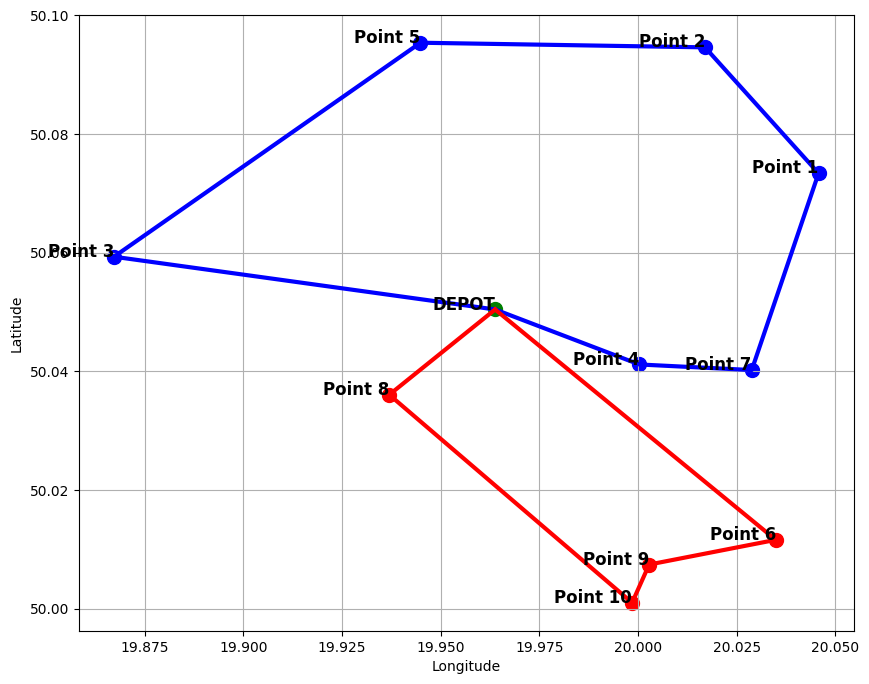

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Snapped Latitude': [50.050428, 50.073384, 50.094609, 50.059320, 50.041162,
                         50.095389, 50.011603, 50.040220, 50.036059, 50.007440, 50.001006],
    'Snapped Longitude': [19.963786, 20.045741, 20.016973, 19.867208, 20.000314,
                          19.944873, 20.034905, 20.028809, 19.936960, 20.002814, 19.998493]
}

df = pd.DataFrame(data)

paths = [
    [0, 3, 5, 2, 1, 7, 4, 0],
    [0, 6, 9, 10, 8, 0]
]

def draw_routes_with_bold_lines(df, paths):
    plt.figure(figsize=(10, 8))

    plt.scatter(df.iloc[0]['Snapped Longitude'], df.iloc[0]['Snapped Latitude'], color='green', s=100)
    plt.text(df.iloc[0]['Snapped Longitude'], df.iloc[0]['Snapped Latitude'],
             'DEPOT', fontsize=12, ha='right', color='black', fontweight='bold')

    colors = ['blue', 'red']

    for idx, path in enumerate(paths):
        for p in path[1:]:
            if p == 0:
                continue
            plt.scatter(df.iloc[p]['Snapped Longitude'], df.iloc[p]['Snapped Latitude'], color=colors[idx], s=100)
            plt.text(df.iloc[p]['Snapped Longitude'], df.iloc[p]['Snapped Latitude'],
                     f'Point {p}', fontsize=12, ha='right', color='black', fontweight='bold')

    for idx, path in enumerate(paths):
        longitudes = [df.iloc[p]['Snapped Longitude'] for p in path]
        latitudes = [df.iloc[p]['Snapped Latitude'] for p in path]
        plt.plot(longitudes, latitudes, color=colors[idx], linewidth=3)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

draw_routes_with_bold_lines(df, paths)


In [ ]:
service_time = 5

In [ ]:
import math

def vrptw(number_of_clients, number_of_vehicles, cost_buffor, a, b, t, T):
      n = number_of_clients
      c = number_of_vehicles
      Q = 100
      M = 10000000

      cost_shiffted = crop_matrix(cost_buffor,n+1)
      cost_shiffted.append(cost_shiffted[0])
      iterator = 0
      for row in cost_shiffted:
        cost_shiffted[iterator].append(cost_shiffted[iterator][0])
        iterator += 1

      T.append(T[0])
      iterator = 0
      for row in T:
        T[iterator].append(T[iterator][0])
        iterator += 1

      prob = pulp.LpProblem("VRPTW", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i,j,k) for i in range(n+1) for j in range(1, n+2) for k in range(c)], cat='Binary')
      s = pulp.LpVariable.dicts("s", [(i,k) for i in range(n+2) for k in range(c)], lowBound=0, cat='Continuous')

      prob += pulp.lpSum(cost_shiffted[i][j] * x[(i,j,k)] for i in range(n+1) for j in range(1, n+2) for k in range(c))

      for j in range(1, n+1):
          prob += pulp.lpSum(x[(i,j,k)] for i in range(n+1) for k in range(c)) == 1

      for i in range(1, n+1):
          prob += pulp.lpSum(x[(i,j,k)] for j in range(1, n+2) for k in range(c)) == 1

      for k in range(c):
          prob += pulp.lpSum(x[i,n+1,k] for i in range(n+1)) == 1

      for k in range(c):
          prob += pulp.lpSum(x[0,j,k] for j in range(1, n+2)) == 1

      for m in range(1, n+1):
        for k in range(c):
          prob += pulp.lpSum(x[(i,m,k)] for i in range(n+1) if i != m) == pulp.lpSum(x[(m,j,k)] for j in range(1,n+2) if j != m)

      for k in range(c):
        prob += x[0,n+1,k] == 0

      for i in range(n+1):
        for j in range(1,n+2):
          for k in range(c):
            if i == j:
              prob += x[(i,j,k)] == 0

      for i in range(n+1):
        for j in range(1,n+2):
          for k in range(c):
            prob += s[(i,k)] + t[i] + T[i][j] <= s[(j,k)] + M*(1 - x[(i,j,k)])

      for i in range(1, n+1):
        for k in range(c):
          prob += M*(pulp.lpSum(x[i,j,k] for j in range(1,n+2)) - 1) + a[i] <= s[(i,k)]

      for i in range(1, n+1):
        for k in range(c):
          prob += s[(i,k)] + t[i] <= b[i] + M*(1 - pulp.lpSum(x[(i,j,k)] for j in range(1,n+2)))


      prob.solve()
      print(pulp.LpStatus[prob.status])

      all_uesd_edges = []
      paths = [[] for _ in range(c)]

      for k in range(c):
          for i in range(n + 1):
              for j in range(1, n + 2):
                  if i != j and pulp.value(x[i,j,k]) == 1:
                      all_uesd_edges.append((i, j))
                      paths[k].append((i, j))

      result_paths = find_paths_vrb(all_uesd_edges, number_of_clients, number_of_clients+1)

      print(result_paths)

In [ ]:
number_of_clients = 10
capacity_of_vehicle = 100
number_of_vehicles = 2
service_time = 5

median = np.median(cost_T)
max_time = math.floor(number_of_clients * median + service_time*number_of_clients/number_of_vehicles) +1

t = [service_time] * (number_of_clients + 10)
a = [0] * (number_of_clients + 1)
b = [max_time] * (number_of_clients + 2)

a = [0, 60, 30, 0, 150, 0, 60, 40, 0, 0, 150]
b = [186, 100, 50, 186, 150, 186, 186, 100, 60, 186, 186, 186]

print(median)
time_window_time = 40

for client in range(number_of_clients + 1):
    a[client] = random.randint(int(median/2), int(max_time - service_time - median))
    b[client] = a[client] + time_window_time

a[0] = 0
b[0] = max_time
print(a[1:])
print(b[1:])

[44, 73, 11, 131, 38, 39, 100, 70, 159, 79]
[84, 113, 51, 171, 78, 79, 140, 110, 199, 119, 186]


In [ ]:
T =  crop_matrix(cost_T,number_of_clients+1)
vrptw(number_of_clients, number_of_vehicles, cost_R, a, b, t, T)

Optimal
[[0, 3, 5, 1, 2, 7, 4, 11], [0, 6, 10, 8, 9, 11]]


In [ ]:
T =  crop_matrix(cost_T,number_of_clients+1)
vrptw(number_of_clients, number_of_vehicles, cost_G, a, b, t, T)

Optimal
[[0, 6, 10, 8, 11], [0, 3, 5, 1, 2, 7, 4, 9, 11]]


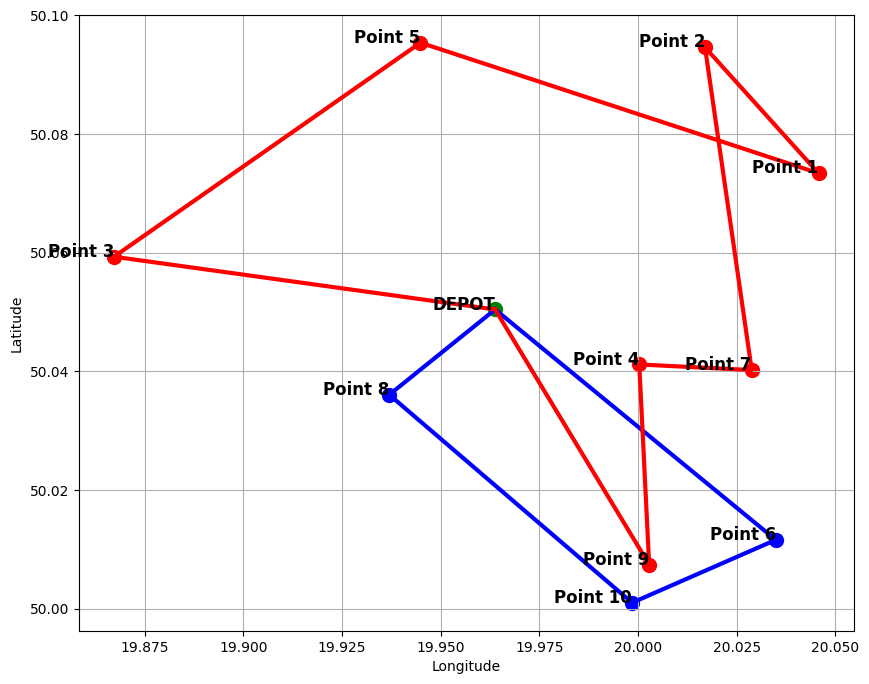

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Snapped Latitude': [50.050428, 50.073384, 50.094609, 50.059320, 50.041162,
                         50.095389, 50.011603, 50.040220, 50.036059, 50.007440, 50.001006],
    'Snapped Longitude': [19.963786, 20.045741, 20.016973, 19.867208, 20.000314,
                          19.944873, 20.034905, 20.028809, 19.936960, 20.002814, 19.998493]
}

df = pd.DataFrame(data)

paths = [
    [0, 6, 10, 8, 0],
    [0, 3, 5, 1, 2, 7, 4, 9, 0]
]

def draw_routes_with_bold_lines(df, paths):
    plt.figure(figsize=(10, 8))

    plt.scatter(df.iloc[0]['Snapped Longitude'], df.iloc[0]['Snapped Latitude'], color='green', s=100)
    plt.text(df.iloc[0]['Snapped Longitude'], df.iloc[0]['Snapped Latitude'],
             'DEPOT', fontsize=12, ha='right', color='black', fontweight='bold')

    colors = ['blue', 'red']

    for idx, path in enumerate(paths):
        for p in path[1:]:
            if p == 0:
                continue
            plt.scatter(df.iloc[p]['Snapped Longitude'], df.iloc[p]['Snapped Latitude'], color=colors[idx], s=100)
            plt.text(df.iloc[p]['Snapped Longitude'], df.iloc[p]['Snapped Latitude'],
                     f'Point {p}', fontsize=12, ha='right', color='black', fontweight='bold')

    for idx, path in enumerate(paths):
        longitudes = [df.iloc[p]['Snapped Longitude'] for p in path]
        latitudes = [df.iloc[p]['Snapped Latitude'] for p in path]
        plt.plot(longitudes, latitudes, color=colors[idx], linewidth=3)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

draw_routes_with_bold_lines(df, paths)


In [ ]:
df = pd.read_csv(os.path.join("", "VISUALIZATION"))
cost_R, cost_T, cost_G = create_cost_matrixes(df)

In [ ]:
df

,Original Latitude,Original Longitude,Snapped Latitude,Snapped Longitude,Real Distance to Point 1,Time to Point 1,Road Distance to Point 1,Real Distance to Point 2,Time to Point 2,Road Distance to Point 2,...,Road Distance to Point 8,Real Distance to Point 9,Time to Point 9,Road Distance to Point 9,Real Distance to Point 10,Time to Point 10,Road Distance to Point 10,Real Distance to Point 11,Time to Point 11,Road Distance to Point 11
0,48.201134,16.377229,48.201104,16.377294,0.00,0,0.0,454.20,352,557.0,...,557.0,403.71,353,535.0,319.89,255,421.0,147.74,147,178.0
1,49.307844,10.429654,49.307638,10.429334,454.20,352,557.0,0.00,0,0.0,...,153.0,829.45,683,1038.0,768.08,589,980.0,324.68,305,422.0
2,48.054160,16.850220,48.054166,16.850226,38.81,37,45.4,492.76,370,604.0,...,610.0,373.19,328,499.0,284.07,230,384.0,185.19,166,219.0
3,52.164518,21.222887,52.164262,21.222439,560.17,411,685.0,824.53,583,1000.0,...,1136.0,374.88,351,485.0,470.63,468,641.0,565.30,436,733.0
4,48.250922,12.787617,48.251042,12.787616,266.74,206,304.0,209.38,194,314.0,...,261.0,665.51,546,846.0,586.61,448,731.0,178.85,206,264.0
5,47.998942,11.182928,47.999008,11.182543,387.49,299,453.0,155.74,157,210.0,...,122.0,788.00,646,1018.0,706.75,548,903.0,297.55,285,382.0
6,53.142452,11.266570,53.142282,11.266962,657.38,564,841.0,430.60,379,558.0,...,683.0,879.34,709,1070.0,879.90,770,1196.0,517.70,455,713.0
7,48.224662,10.094762,48.224814,10.094667,466.79,356,557.0,122.90,100,153.0,...,0.0,863.70,699,1101.0,786.66,601,986.0,364.38,339,484.0
8,48.812403,21.763980,48.811971,21.764184,403.71,353,535.0,829.45,683,1038.0,...,1101.0,0.00,0,0.0,126.37,154,184.0,505.66,465,660.0
9,47.948847,20.653881,47.948932,20.654146,319.89,255,421.0,768.08,589,980.0,...,986.0,126.37,154,184.0,0.00,0,0.0,445.22,385,600.0


In [ ]:
demand_of_client = generate_list(number_of_clients + 1, 0.8* capacity_of_vehicle * number_of_vehicles)

In [ ]:
def vrpsdp(number_of_clients, number_of_vehicles, cost_buffor,p,d):
  capacity_of_vehicle = 100
  cost_shiffted = crop_matrix(cost_buffor, number_of_clients + 1)

  vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)
  m = number_of_vehicles
  x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(number_of_clients+1) for j in range(number_of_clients+1) for k in range(m)], cat='Binary')
  y = pulp.LpVariable.dicts("y", [(i, j) for i in range(number_of_clients+1) for j in range(number_of_clients+1)], lowBound=0, cat='Continuous')
  z = pulp.LpVariable.dicts("z", [(i, j) for i in range(number_of_clients+1) for j in range(number_of_clients+1)], lowBound=0, cat='Continuous')

  vrpsdp += pulp.lpSum(cost_shiffted[i][j] * x[i, j, k] for k in range(m) for i in range(number_of_clients+1) for j in range(number_of_clients+1) if i != j)
  Q = capacity_of_vehicle

  for j in range(1, number_of_clients+1):
      vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(number_of_clients+1) if i != j) == 1

  for k in range(m):
    for j in range(number_of_clients+1):
      vrpsdp += pulp.lpSum(x[i,j,k] for i in range(number_of_clients+1)) - pulp.lpSum(x[j,i,k] for i in range(number_of_clients+1)) == 0

  for k in range(m):
    vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, number_of_clients+1)) == 1


  for j in range(1, number_of_clients+1):
    vrpsdp += pulp.lpSum(y[j,i] for i in range(number_of_clients+1)) - pulp.lpSum(y[i,j] for i in range(number_of_clients+1)) == p[j]

  for j in range(1, number_of_clients+1):
    vrpsdp += pulp.lpSum(z[i,j] for i in range(number_of_clients+1)) - pulp.lpSum(z[j,i] for i in range(number_of_clients+1)) == d[j]

  for i in range(number_of_clients+1):
    for j in range(number_of_clients+1):
      if i != j:
        vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

  vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, number_of_clients+1) for k in range(m)) == m
  for i in range(1,number_of_clients+1):
    vrpsdp += pulp.lpSum(x[i,j,k] for j in range(number_of_clients+1) for k in range(m) if i != j) == 1

  vrpsdp.solve()

  print(pulp.value(vrpsdp.objective))

  all_uesd_edges_road = []
  paths = [[] for _ in range(number_of_vehicles)]

  for k in range(number_of_vehicles):
      for i in range(number_of_clients + 1):
          for j in range(number_of_clients + 1):
              if i != j and pulp.value(x[i,j,k]) == 1:
                  all_uesd_edges_road.append((i, j))
                  paths[k].append((i, j))
  print(paths)
  result = find_paths_vrb(all_uesd_edges_road, 2)
  print(result)

In [ ]:
number_of_clients = 10
capacity_of_vehicle = 100
number_of_vehicles = 2

p = generate_list(number_of_clients + 1, 0.85 * capacity_of_vehicle * number_of_vehicles)
d = generate_list(number_of_clients + 1, 0.85 * capacity_of_vehicle * number_of_vehicles)

In [ ]:
print(d[1:])
print(p[1:])

[27.97, 23.88, 8.32, 13.23, 6.48, 26.86, 6.21, 25.28, 22.68, 9.089999999999963]
[10.83, 2.9, 31.27, 30.13, 11.94, 2.07, 30.75, 3.56, 20.72, 25.83000000000001]


In [ ]:
vrpsdp(number_of_clients, number_of_vehicles, cost_R ,p,d)

4144.4
[[(0, 2), (2, 9), (3, 10), (8, 3), (9, 8), (10, 0)], [(0, 6), (1, 7), (4, 0), (5, 4), (6, 1), (7, 5)]]
['0->2->9->8->3->10->0', '0->6->1->7->5->4->0']


In [ ]:
vrpsdp(number_of_clients, number_of_vehicles, cost_G ,p,d)

3232.9900000000002
[[(0, 6), (2, 0), (3, 8), (6, 3), (8, 9), (9, 2)], [(0, 10), (1, 7), (4, 0), (5, 4), (7, 5), (10, 1)]]
['0->6->3->8->9->2->0', '0->10->1->7->5->4->0']


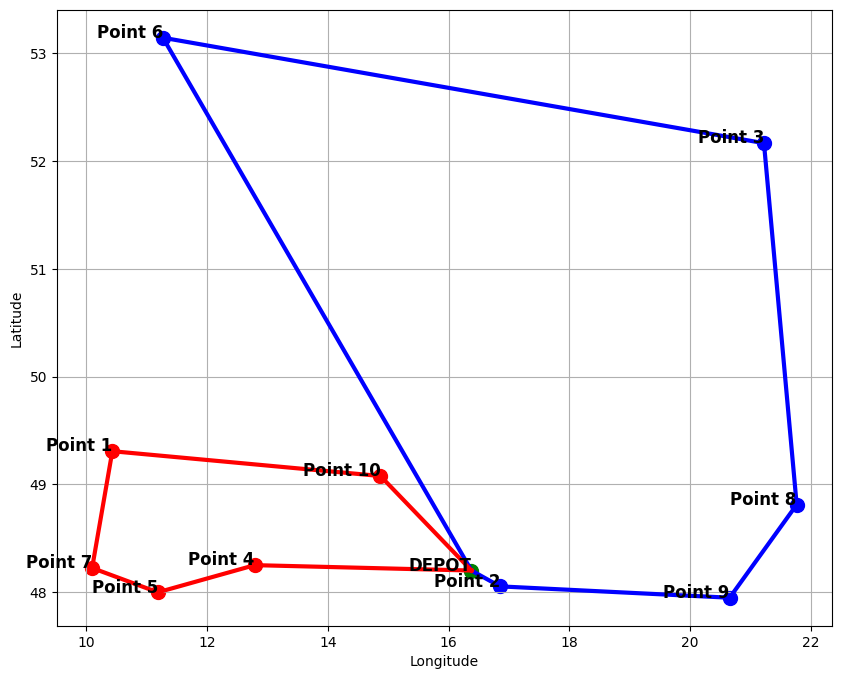

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Snapped Latitude': [48.201104, 49.307638, 48.054166, 52.164262, 48.251042,
                         47.999008, 53.142282, 48.224814, 48.811971, 47.948932, 49.077602],
    'Snapped Longitude': [16.377294, 10.429334, 16.850226, 21.222439, 12.787616,
                          11.182543, 11.266962, 10.094667, 21.764184, 20.654146, 14.870614]
}

df = pd.DataFrame(data)

paths = [
    [0, 6, 3, 8, 9, 2, 0],
    [0, 10, 1, 7, 5, 4, 0]
]

def draw_routes_with_bold_lines(df, paths):
    plt.figure(figsize=(10, 8))

    plt.scatter(df.iloc[0]['Snapped Longitude'], df.iloc[0]['Snapped Latitude'], color='green', s=100)
    plt.text(df.iloc[0]['Snapped Longitude'], df.iloc[0]['Snapped Latitude'],
             'DEPOT', fontsize=12, ha='right', color='black', fontweight='bold')

    colors = ['blue', 'red']

    for idx, path in enumerate(paths):
        for p in path[1:]:
            if p == 0:
                continue
            plt.scatter(df.iloc[p]['Snapped Longitude'], df.iloc[p]['Snapped Latitude'], color=colors[idx], s=100)
            plt.text(df.iloc[p]['Snapped Longitude'], df.iloc[p]['Snapped Latitude'],
                     f'Point {p}', fontsize=12, ha='right', color='black', fontweight='bold')

    for idx, path in enumerate(paths):
        longitudes = [df.iloc[p]['Snapped Longitude'] for p in path]
        latitudes = [df.iloc[p]['Snapped Latitude'] for p in path]
        plt.plot(longitudes, latitudes, color=colors[idx], linewidth=3)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

draw_routes_with_bold_lines(df, paths)


In [ ]:
def vrpb(number_of_clients, number_of_vehicles, cost_buffor, p_d):
    Q = 100
    m = number_of_vehicles
    cost_shiffted = crop_matrix(cost_buffor,number_of_clients + 1)

    L_B = list(range(1, number_of_clients + 1))
    SOURCE = 0

    L = [index for index, value in enumerate(p) if value == 0]
    L0 = L[:]
    L0.insert(0,0)
    B = [index for index, value in enumerate(d) if value == 0]

    B0 = B[:]
    B0.insert(0,0)
    Cu = L_B

    V = list(range(0, number_of_clients + 1))

    K = m
    D = p_d
    Kl = K
    Kb = K

    s = pulp.LpVariable.dicts('s', [(i, j) for i in V for j in V if i != j], cat = pulp.LpBinary)
    e = pulp.LpVariable.dicts('e', [(i, j) for i in L for j in B0 if i != j], cat = pulp.LpBinary)
    l = pulp.LpVariable.dicts('l', [(i, j) for i in V for j in V if i != j], 0, cat = "Continuous")

    model = pulp.LpProblem("vehicle_routing", pulp.LpMinimize)

    cost_function_model = pulp.lpSum(s[i,j] * cost_shiffted[i][j] for i in V for j in V if i != j) + pulp.lpSum(e[i,j] * cost_shiffted[i][j] for i in L for j in B0 if i != j)
    model += cost_function_model

    model += pulp.lpSum(s[i,j] for i in L0 for j in L if i != j) == len(L)

    for j in L:
      model += pulp.lpSum(l[i,j] for i in L0 if i != j) - pulp.lpSum(l[j,k] for k in L0 if k != j) == D[j]

    for j in L:
      model += pulp.lpSum(s[i,j] for i in L0 if i != j) == 1

    for j in L:
      model += pulp.lpSum(s[j,k] for k in L if k != j) + pulp.lpSum(e[j,k] for k in B0 if k != j)  ==  pulp.lpSum(s[(i,j)] for i in L0 if i != j)

    for j in L:
      for i in L0:
        if i != j:
          model += l[(i,j)] <= Q * s[(i,j)]

    fraaction7 = pulp.lpSum(D[j] for j in L)/Q
    model += pulp.lpSum(s[0,j] for j in L) >= max(float(fraaction7.value()),Kl)

    model += pulp.lpSum(s[i,j] for i in B for j in B0 if i != j) == len(B)

    for j in B:
      model += pulp.lpSum(l[i,j] for i in B if i != j) - pulp.lpSum(l[(j,k)] for k in B0 if k != j) == -D[j]

    for j in B:
      model += pulp.lpSum(s[j,i] for i in B0 if j != i) == 1

    for j in B:
      model += pulp.lpSum(s[k,j] for k in B if k != j) + pulp.lpSum(e[k,j] for k in L) == pulp.lpSum(s[(j,i)] for i in B0 if j != i)

    for j in B0:
      for i in B:
        if i != j:
          model += l[i,j] <= Q * s[i,j]

    fraaction13 = pulp.lpSum(D[j] for j in B)/Q
    model += max(int(fraaction13.value()),Kb) <= pulp.lpSum(s[i,0] for i in B)
    model += pulp.lpSum(s[(i,0)] for i in B) <= pulp.lpSum(s[0, j] for j in L)

    model += pulp.lpSum(s[i,0] for i in B) + pulp.lpSum(e[i, 0] for i in L) == pulp.lpSum(s[0,j] for j in L)

    for i in V:
      for j in V:
        if i != j:
          model += s[i,j] + s[j,i] <= 1

    model += pulp.lpSum(s[i,j] for i in B for j in L if i != j) == 0

    model += pulp.lpSum(s[0, j] for j in B) == 0

    model += pulp.lpSum(s[i,j] for i in L for j in B0 if i != j) == 0


    model.solve()
    print(pulp.value(model.objective))

    all_uesd_edges_road = []

    for i in V:
      for j in V:
        if i != j:
          if  s[i,j].varValue == 1:
            all_uesd_edges_road.append((i,j))

    for i in L:
      for j in B0:
        if i != j:
          if  e[i,j].varValue == 1:
            all_uesd_edges_road.append((i,j))

    result = find_paths_vrb(all_uesd_edges_road, 2)

    print(result)

In [ ]:
number_of_clients = 10
number_of_vehicles = 2

d = generate_demand_list(number_of_clients + 1, 3, 0.7 * 100 * number_of_vehicles)
p_d = replace_zeros_with_sum(d, 0.5 * 100 * number_of_vehicles)
p = [-1]

for iterator in range(1,len(d)):
  if d[iterator] == 0:
    p.append(p_d[iterator])
  else:
    p.append(0)

In [ ]:
vrpb(number_of_clients, number_of_vehicles, cost_R, p_d)

4071.4
['0->2->8->9->0', '0->3->6->1->7->5->4->10->0']


In [ ]:
vrpb(number_of_clients, number_of_vehicles, cost_G, p_d)

3158.65
['0->2->3->8->9->0', '0->6->1->7->5->4->10->0']


In [ ]:
print(d[1:])
print(p[1:])

[2.84, 33.26, 42.80999999999999, 0, 31.76, 7.44, 15.14, 6.75, 0, 0]
[0, 0, 0, 46.62, 0, 0, 0, 0, 30.2, 23.18]


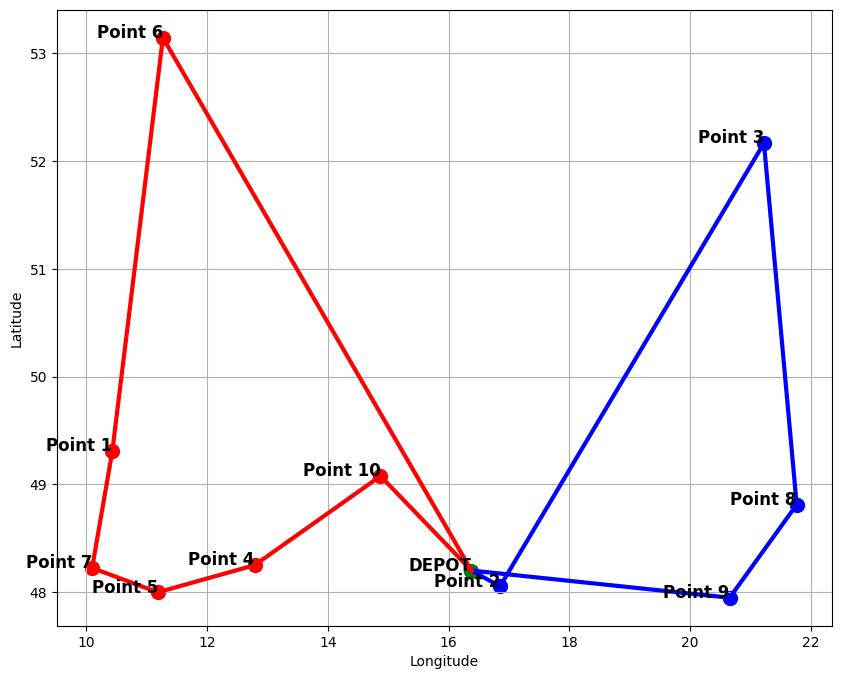

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Snapped Latitude': [48.201104, 49.307638, 48.054166, 52.164262, 48.251042,
                         47.999008, 53.142282, 48.224814, 48.811971, 47.948932, 49.077602],
    'Snapped Longitude': [16.377294, 10.429334, 16.850226, 21.222439, 12.787616,
                          11.182543, 11.266962, 10.094667, 21.764184, 20.654146, 14.870614]
}

df = pd.DataFrame(data)

paths = [
    [0, 2, 3, 8, 9, 0],
    [0, 6, 1, 7, 5, 4, 10, 0]
]

def draw_routes_with_bold_lines(df, paths):
    plt.figure(figsize=(10, 8))

    plt.scatter(df.iloc[0]['Snapped Longitude'], df.iloc[0]['Snapped Latitude'], color='green', s=100)
    plt.text(df.iloc[0]['Snapped Longitude'], df.iloc[0]['Snapped Latitude'],
             'DEPOT', fontsize=12, ha='right', color='black', fontweight='bold')

    colors = ['blue', 'red']

    for idx, path in enumerate(paths):
        for p in path[1:]:
            if p == 0:
                continue
            plt.scatter(df.iloc[p]['Snapped Longitude'], df.iloc[p]['Snapped Latitude'], color=colors[idx], s=100)
            plt.text(df.iloc[p]['Snapped Longitude'], df.iloc[p]['Snapped Latitude'],
                     f'Point {p}', fontsize=12, ha='right', color='black', fontweight='bold')

    for idx, path in enumerate(paths):
        longitudes = [df.iloc[p]['Snapped Longitude'] for p in path]
        latitudes = [df.iloc[p]['Snapped Latitude'] for p in path]
        plt.plot(longitudes, latitudes, color=colors[idx], linewidth=3)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

draw_routes_with_bold_lines(df, paths)
